# Process recount2 data
This notebook does the following:

1. Selects template experiment
2. Downloads subset of recount2 data, including the template experiment (subset of random experiments + 1 template experiment)
3. Train VAE on subset of recount2 data

In [1]:
%load_ext autoreload
%load_ext rpy2.ipython
%autoreload 2

import os
import numpy as np
import pandas as pd

from ponyo import utils, train_vae_modules
from generic_expression_patterns_modules import process

/home/dhu/miniconda3/envs/generic_expression/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/dhu/miniconda3/envs/generic_expression/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/dhu/miniconda3/envs/generic_expression/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/dhu/minico

In [2]:
# Read in config variables
base_dir = os.path.abspath(
    os.path.join(os.getcwd(), "../")
)

config_file = os.path.abspath(
    os.path.join(base_dir, "configs", "config_test.tsv")
)
params = utils.read_config(config_file)

### Select template experiment

We manually selected bioproject [SRP012656](https://www.ncbi.nlm.nih.gov/geo/query/acc.cgi?acc=GSE37764), which contains primary non-small cell lung adenocarcinoma tumors and adjacent normal tissues of 6 never-smoker Korean female patients with 2 replicates each.

In [3]:
# Load params
local_dir = params["local_dir"]
dataset_name = params['dataset_name']
NN_architecture = params['NN_architecture']
project_id = params['project_id']
template_data_file = params['template_data_file']
original_compendium_file = params['compendium_data_file']
normalized_data_file = params['normalized_compendium_data_file']
scaler_file = params['scaler_transform_file']

In [4]:
# Create analysis output directory
os.makedirs(local_dir, exist_ok=True)

In [5]:
# Read data
template_data = pd.read_csv(
    template_data_file,
    header=0,
    sep='\t',
    index_col=0
)

print(template_data.shape)
assert(template_data.shape[0] == 24)
template_data.head()

(24, 17787)


,HSPA1L,FAM171B,SLC9C2,RAB3D,ZRANB2,TULP4,METTL18,SDK2,ZFYVE1,VIP,...,RMDN3,GFOD2,OR10J1,GAB1,DSCC1,KCNN2,SLC45A2,B4GALNT3,PADI1,PCDHA10
SRR493937,80,155,19,845,1348,1571,56,610,686,11,...,1672,1115,0,777,43,32,5,938,2,438
SRR493938,127,124,16,858,1381,1660,63,601,688,8,...,1689,1053,0,840,48,37,5,830,4,438
SRR493939,116,489,38,2066,1554,1689,130,508,698,4,...,1414,601,0,882,118,37,18,3723,59,784
SRR493940,116,482,41,2068,1558,1756,156,547,710,2,...,1409,584,0,963,105,47,3,3862,51,840
SRR493941,113,224,16,1764,2180,1152,106,592,1339,44,...,2112,1082,0,2496,81,75,4,807,0,837


### Normalize compendium 

In [6]:
# Read data
original_compendium = pd.read_table(
    original_compendium_file,
    header=0,
    sep='\t',
    index_col=0
)

print(original_compendium.shape)
original_compendium.head()

(92, 17787)


,HSPA1L,FAM171B,SLC9C2,RAB3D,ZRANB2,TULP4,METTL18,SDK2,ZFYVE1,VIP,...,RMDN3,GFOD2,OR10J1,GAB1,DSCC1,KCNN2,SLC45A2,B4GALNT3,PADI1,PCDHA10
SRR493816,147,113,1,2194,737,1099,94,136,2084,12,...,1299,1336,0,309,71,104,2,150,41,893
SRR493817,346,85,1,2046,621,1181,63,15,2597,2,...,1760,1029,0,375,109,26,0,267,27,787
SRR547975,15,587,0,105,3422,2542,244,0,655,0,...,1281,706,0,492,548,0,3,12,5,0
SRR547973,76,34,0,4529,1330,1814,295,8,438,0,...,616,594,0,958,249,0,0,501,16,215
SRR547968,143,5,0,2780,1984,2240,175,0,506,0,...,1242,855,0,855,797,4,25,237,55,5


In [7]:
process.normalize_compendium(
    original_compendium_file,
    normalized_data_file,
    scaler_file
)

### Train VAE 
Performed exploratory analysis of compendium data [here](../explore_data/viz_recount2_compendium.ipynb) to help interpret loss curve.

In [8]:
# Create VAE directories
output_dirs = [
    os.path.join(base_dir, dataset_name, "models"),
    os.path.join(base_dir, dataset_name, "logs")
]

for each_dir in output_dirs:
    new_dir = os.path.join(each_dir, NN_architecture)
    os.makedirs(new_dir, exist_ok=True)

input dataset contains 92 samples and 17787 genes
Instructions for updating:
Colocations handled automatically by placer.
tracking <tf.Variable 'Variable:0' shape=() dtype=float32> beta
Instructions for updating:
Use tf.cast instead.


/home/dhu/miniconda3/envs/generic_expression/lib/python3.7/site-packages/keras/engine/training_utils.py:819: UserWarning: Output custom_variational_layer_1 missing from loss dictionary. We assume this was done on purpose. The fit and evaluate APIs will not be expecting any data to be passed to custom_variational_layer_1.
  'be expecting any data to be passed to {0}.'.format(name))


Train on 83 samples, validate on 9 samples
Epoch 1/5
83/83 [==============================] - 26s 309ms/step - loss: 9190.3781 - val_loss: 38080.2969
Epoch 2/5
83/83 [==============================] - 25s 305ms/step - loss: 8197.8554 - val_loss: 12520.5080
Epoch 3/5
83/83 [==============================] - 25s 305ms/step - loss: 7896.1983 - val_loss: 9229.7250
Epoch 4/5
83/83 [==============================] - 25s 305ms/step - loss: 8008.6557 - val_loss: 9005.8373
Epoch 5/5
83/83 [==============================] - 25s 304ms/step - loss: 7861.3925 - val_loss: 8830.7388


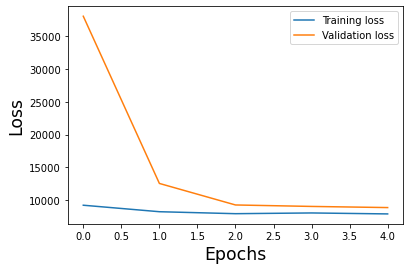

In [9]:
# Train VAE on new compendium data
train_vae_modules.train_vae(
    config_file,
    normalized_data_file
)

In [10]:
# Test reproducibility
expected_log = "data/test_vae_logs.tsv"
actual_log = "logs/NN_2500_30/tybalt_2layer_30latent_stats.tsv"
assert np.all(
    np.isclose(
        pd.read_csv(expected_log, sep="\t").values,
        pd.read_csv(actual_log, sep="\t").values
    )
)